100%|██████████| 100/100 [14:00<00:00,  8.41s/trial, best loss: 0.6189470790648768]
Best hyperparameters:  {'max_depth': 40, 'max_features': 0.10185878458515446, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 280}
RMSE: 0.6189470790648768
R2: 0.5979288802667865


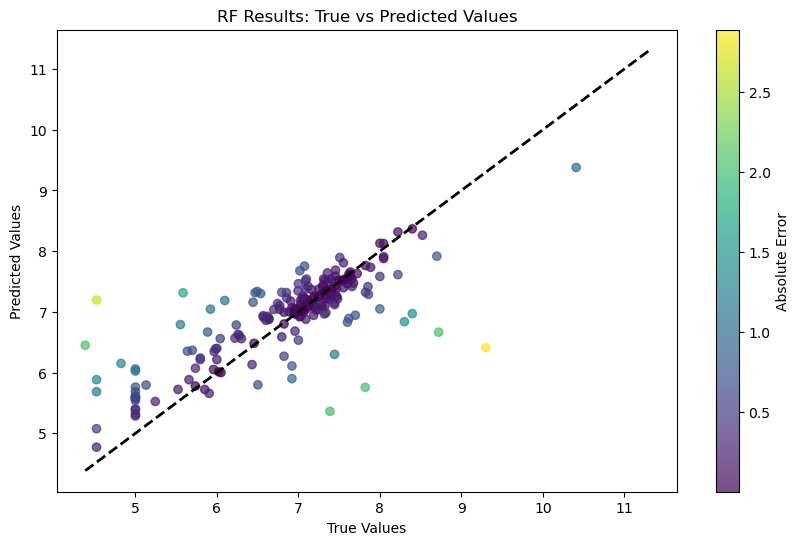

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import logging
import joblib
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(30)

# Set up logging
logging.basicConfig(filename='hyperopt_rf_log.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Load the dataset
file_path = '/home/vesper/文档/lab/CDK9/dataset/cleaned_CDK9.csv'
data = pd.read_csv(file_path)

# Function to compute RDKit fingerprint
def compute_rdkit_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return RDKFingerprint(mol)
    else:
        return None

# Filter out invalid molecules
data = data[data['smiles'] != '0']  # Remove invalid SMILES
data['fingerprint'] = data['smiles'].apply(compute_rdkit_fingerprint)
data = data.dropna(subset=['fingerprint'])

# Convert fingerprints to numpy array
X = np.array([fp.ToBitString() for fp in data['fingerprint']])
X = np.array([list(map(int, list(x))) for x in X])

# Target variable
y = data['pIC50'].astype(float)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter space for Hyperopt
param_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
    'max_features': hp.uniform('max_features', 0.1, 1.0)
}

# Define the objective function
def objective(params):
    # Convert the hyperparameters to the correct types
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    # Train the model
    rf = RandomForestRegressor(**params, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    # Log the parameters and the resulting RMSE
    logging.info(f"Params: {params}, RMSE: {rmse}")
    
    return {'loss': rmse, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = {key: int(value) if key in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'] else value for key, value in best.items()}
print("Best hyperparameters: ", best_params)

# Train the final model with the best hyperparameters
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)

# Save the model to a file
joblib.dump(rf, 'rf_model.pkl')

# Predict on the test set
y_pred = rf.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

# Plot the results and save as PNG
plt.figure(figsize=(10, 6))
errors = np.abs(y_test - y_pred)
scatter = plt.scatter(y_test, y_pred, c=errors, cmap='viridis', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('RF Results: True vs Predicted Values')
plt.colorbar(scatter, label='Absolute Error')
plt.savefig('RF_results.png')
plt.show()

# Load the model from the file
rf_loaded = joblib.load('rf_model.pkl')

# Predict using the loaded model
y_pred_loaded = rf_loaded.predict(X_test)
